# A05 Q2: Autoencoders

## Preliminaries

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
torch.__version__

'1.10.2'

In [17]:
# In case you are fortunate enough to have access to a GPU...
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
def plot_latent(h, t_class):
    '''
     plot_latent(h, t_class)
     Plots the 2D points in h, coloured according to their class.
    '''
    colours = ['pink', 'r', 'orange', 'tab:brown', 'y', 'g', 'teal', 'b', \
               'mediumpurple', 'gray', 'b']

    plt.figure(figsize=(7,6))
    for c in range(10):
        hh = h[t_class==c]
        if len(hh)>0:
            plt.scatter(hh[:,0], hh[:,1], c=colours[c], label=f'{c}')
    plt.axis('square');
    plt.legend(loc=(1.02, 0.5))
    plt.tight_layout();

# Dataset: MNIST

In [19]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28

ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [20]:
class MNIST(torch.utils.data.Dataset):
    def __init__(self, n=1024, img_size=28):
        '''
         ds = MNIST(n=1024, img_size=28)
         
         Creates an MNIST dataset of n digit images of the specified size.
         The images are converted to 1D vectors of size (img_size)**2.
        '''
        self.img_size = img_size
        self.n = n
        ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))
        ds_n = torch.utils.data.Subset(ds_full, range(self.n))
        self.x = ds_n

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        '''ds.__getitem__(idx) returns the image and class for a sample.
        '''
        x = self.x[idx][0]
        t = self.x[idx][1]
        return x, t
    
    def draw(self, x=None, idx=None):
        '''ds.draw(x=None, idx=None)
           Draws image x, or the image for index idx. If no argument is
           given, it chooses an index randomly.
        '''
        if x is not None:
            # Do nothing
            pass
        elif idx is not None:
            x = self.x[idx][0]
        else:
            r = np.random.randint(0, high=self.n)
            x = self.x[r][0]
        with torch.no_grad():
            plt.imshow(x.reshape((self.img_size, self.img_size)).detach().numpy(), cmap='gray');
            plt.axis('off');

In [21]:
ds = MNIST()

In [22]:
x, t = ds.__getitem__(12)

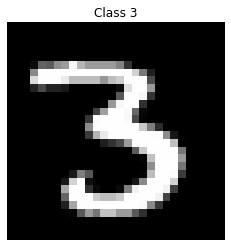

In [23]:
plt.figure()
ds.draw(x=x)
plt.title(f'Class {t}');

## Create some `DataLoader`s

In [24]:
# Batched, for training
batch_size_train = 64
train_dl = torch.utils.data.DataLoader(ds, batch_size=batch_size_train, shuffle=True)

In [25]:
# A single batch, for plotting
train_all = torch.utils.data.DataLoader(ds, batch_size=1024, shuffle=False)

# A. Complete the `MyAE` class

In [26]:
class MyAE(nn.Module):
    '''
     net = MyAE(img_size=28, embedding_dim=2)
     
     Create an autoencoder for imput images of size (img_size x img_size),
     with an embedding (latent) layer of (embedding_dim) neurons.
     
     Inputs:
       img_size       size of input images
                      Input samples will be (img_size**2) vectors.
       embedding_dim  number of nodes in embedding (latent) layer
       
     Usage:
       net = MyAE()
       y = net(x)         # returns output
       h = net.encode(x)  # returns latent vectors
    '''
    def __init__(self, img_size=28, embedding_dim=2):
        self.img_size = img_size
        self.embedding_dim = embedding_dim
        self.losses = []
        super().__init__()
        
        # #===== These lines are just placeholders =====
        # self.encode = nn.Linear(self.img_size**2, 2) # replace
        # self.decode = nn.Linear(2, self.img_size**2) # replace
        # for p in self.parameters():  # replace
        #     p[:] = 0.  # replace
        # #===== YOUR CODE HERE =====
        hidden1_nodes = 200
        hidden2_nodes = 40
        hidden3_nodes = 4
        self.encode = nn.Sequential(
            nn.Linear(img_size**2,hidden1_nodes),
            nn.LeakyReLU(),
            nn.Linear(hidden1_nodes,hidden2_nodes),
            nn.LeakyReLU(),
            nn.Linear(hidden2_nodes,hidden3_nodes),
            nn.LeakyReLU(),
            nn.Linear(hidden3_nodes,embedding_dim),
            nn.Sigmoid()
        )

        self.decode = nn.Sequential(
            nn.Linear(embedding_dim,hidden3_nodes),
            nn.LeakyReLU(),
            nn.Linear(hidden3_nodes,hidden2_nodes),
            nn.LeakyReLU(),
            nn.Linear(hidden2_nodes,hidden1_nodes),
            nn.LeakyReLU(),
            nn.Linear(hidden1_nodes, img_size**2),
            nn.Sigmoid()
        )
        
        
        
    def forward(self, x):
        #===== YOUR CODE HERE =====
        # return x  # replace this line
        self.h = self.encode(x)
        return self.decode(self.h)

    
    def learn(self, dl, epochs=10, optimizer=None, loss_fcn=None):
        '''
         net.learn(dl, epochs=10, optimizer=None, loss_fcn=None)
         
         Train the network on the dataset delivered by the dataloader dl.
         
         Inputs:
          dl        DataLoader object
          epochs    number of epochs to train
          optimizer PyTorch optimizer function
          loss_fcn  PyTorch loss function
        '''
        if optimizer is None or loss_fcn is None:
            print('Need to specify an optimizer and loss function')
            return

        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            count = 0.
            for x, t in dl:
                t = t.to(device)
                x = x.to(device)   # for use with a GPU
                y = self(x)
                loss = loss_fcn(y, x)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()*len(t)
                count += 1.
            self.losses.append(total_loss/len(dl.dataset))

        plt.figure(figsize=(6,4))
        plt.plot(self.losses); plt.yscale('log');

# B. Create and train the network

In [27]:
net = MyAE(img_size=img_size, embedding_dim=2)
net.to(device)
losses = []

100%|██████████| 10000/10000 [32:19<00:00,  5.16it/s]


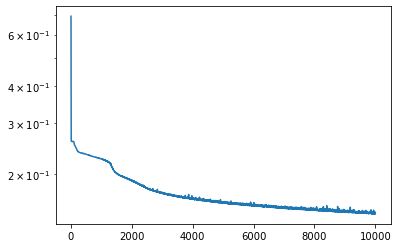

In [28]:
loss_fcn = nn.BCELoss(reduction='mean')
optim = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
net.learn(train_dl,epochs=10000, optimizer=optim,loss_fcn=loss_fcn)

In [29]:
# Uncomment the following line if you want to save your network.
torch.save(net.to('cpu'), 'my_AE.pt')

# The corresponding code to reload the network is below.
#net = torch.load('my_AE.pt')
# Remember to send it to the GPU, if you're using one.
#net.to(device)

# C. Plot the latent space

In [30]:
batch = next(iter(train_all))

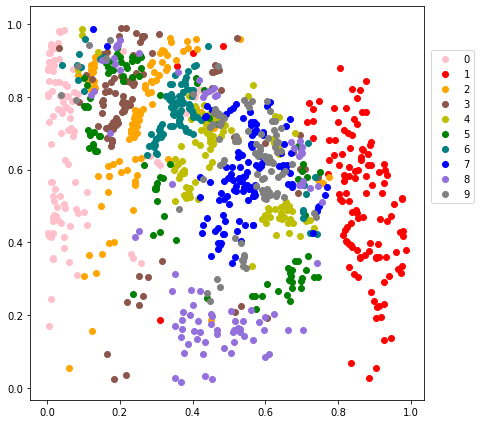

In [31]:
h = net.encode(batch[0]).cpu().detach().numpy()
t_class = batch[1] # Replace this line
plot_latent(h, t_class)


# D. Plot reconstructed digit images

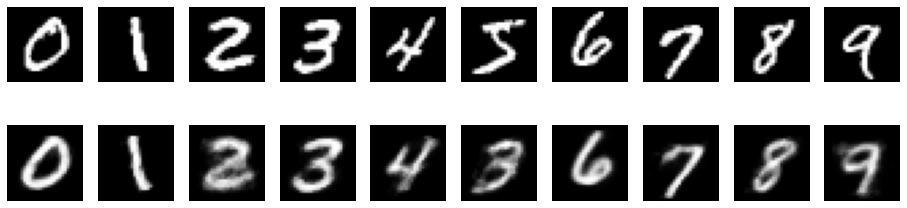

In [158]:
num_index = [1,6,25,7,9,0,13,15,17,4]
plt.figure(figsize=(16, 4))
for k in range(len(num_index)):
    plt.subplot(2,len(num_index),k+1);
    x, t = ds.__getitem__(num_index[k])
    ds.draw(x=x)
    plt.subplot(2,len(num_index),k+11);
    ds.draw(x=net(x))


# E. Selected Reconstructions

## E.(a)

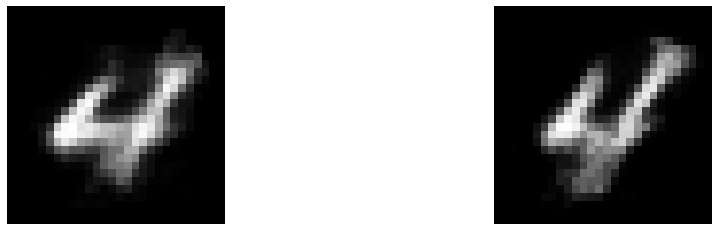

In [175]:
A=torch.tensor([0.37,0.6])
B=torch.tensor([0.65,0.45])
plt.figure(figsize=(16,4))
plt.subplot(1,2,1);
ds.draw(x=net.decode(A))
plt.subplot(1,2,2);
ds.draw(x=net.decode(B))

## E.(b)

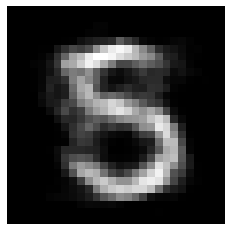

In [176]:
C = torch.tensor([0.2,0.9])
plt.figure(figsize=(16,4))
ds.draw(x=net.decode(C))

## E.(c)

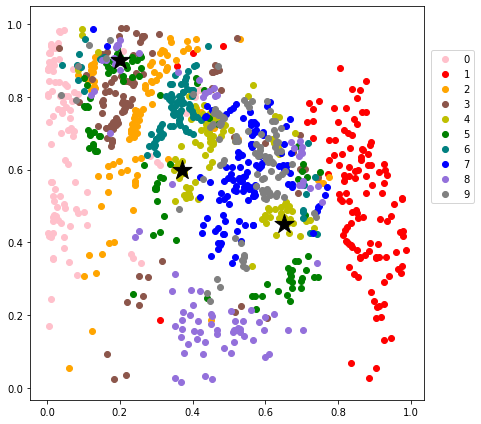

In [177]:
plot_latent(h, t_class)
plt.scatter(A[0],A[1],marker="*",s=400,c='black')
plt.scatter(B[0],B[1],marker="*",s=400,c='black')
plt.scatter(C[0],C[1],marker="*",s=400,c='black')